# Traffic Accident Statistical Analysis in Python

## Key Objectives

This notebook extends the concepts covered in DT503 week 3 using Python's data analysis tools. We perform data import, cleaning, exploratory data analysis (EDA), and advanced multivariate techniques, such as PCA, Factor Analysis, and Cluster Analysis. Hypothesis testing and ANOVA are used to validate patterns in the data, enhancing insights.


1. **Dimensionality Reduction** with PCA
2. **Cluster Analysis** for grouping accident data
3. **Discriminant Analysis** for classification tasks
4. **Hypothesis Testing** for severity comparison
5. **ANOVA** for comparing severity across groups
6. **Variance Analysis** for identifying fluctuating patterns in accident severity

---

In [17]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind
from statsmodels.formula.api import ols
import statsmodels.api as sm
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

## 1. Data Import and Preparation

In this section, we load the traffic accident dataset and prepare it by checking for missing values and ensuring correct data types. Data quality is crucial for reliable analysis. Ensuring accurate data types and handling missing values helps maintain data integrity.

In [58]:
# Load the data
data = pd.read_csv('dft-road-casualty-statistics-collision-2023.csv', low_memory=False)
data.head()  # Display the first few rows to understand the data structure

,accident_index,accident_year,accident_reference,location_easting_osgr,location_northing_osgr,longitude,latitude,police_force,accident_severity,number_of_vehicles,...,light_conditions,weather_conditions,road_surface_conditions,special_conditions_at_site,carriageway_hazards,urban_or_rural_area,did_police_officer_attend_scene_of_accident,trunk_road_flag,lsoa_of_accident_location,enhanced_severity_collision
0,2023010419171,2023,010419171,525060.0,170416.0,-0.202878,51.418974,1,3,1,...,4,8,2,0,0,1,1,2,E01003383,-1
1,2023010419183,2023,010419183,535463.0,198745.0,-0.042464,51.671155,1,3,3,...,4,1,1,0,0,1,1,2,E01001547,-1
2,2023010419189,2023,010419189,508702.0,177696.0,-0.435789,51.487777,1,3,2,...,4,1,1,0,0,1,1,2,E01002448,-1
3,2023010419191,2023,010419191,520341.0,190175.0,-0.263972,51.597575,1,3,2,...,4,9,1,0,0,1,1,2,E01000129,-1
4,2023010419192,2023,010419192,527255.0,176963.0,-0.168976,51.477324,1,3,2,...,4,1,1,0,0,1,1,2,E01004583,-1


### 1.1 Check for Missing Values and Data Types

Checking for missing values helps identify gaps in the data. Proper data types for each column support accurate calculations in later analyses.

In [19]:
# Check for missing values
missing_values = data.isnull().sum()
print("Missing values in each column:")
print(missing_values[missing_values > 0])  # Display only columns with missing values

# Drop rows with missing values
data = data.dropna()

# Convert data types if necessary
data['accident_severity'] = data['accident_severity'].astype(int)
data['number_of_vehicles'] = data['number_of_vehicles'].astype(int)
data['day_of_week'] = data['day_of_week'].astype(int)

Missing values in each column:
location_easting_osgr     12
location_northing_osgr    12
longitude                 12
latitude                  12
dtype: int64


## 2. Principal Component Analysis (PCA)

To reduce the dimensionality of the dataset while preserving essential patterns. PCA simplifies complex datasets by transforming correlated variables into uncorrelated principal components.

PCA is valuable for simplifying datasets, making it easier to detect trends and patterns visually and computationally.

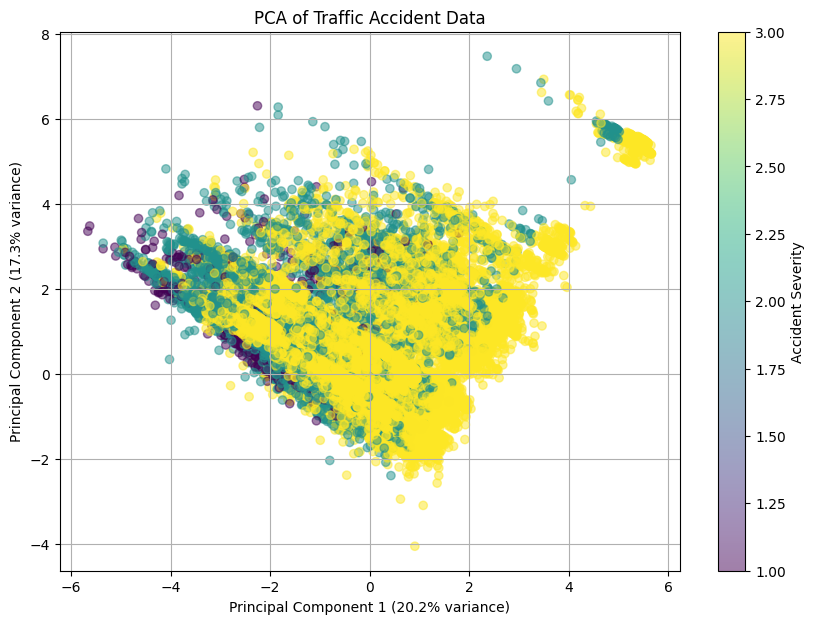

In [55]:
# Select and preprocess features for PCA
features = data[['accident_severity', 'number_of_vehicles', 'latitude', 'longitude', 'speed_limit']].copy()
features['time'] = data['time'].str[:2].astype(float)  # Extract hour from time
features['weather_conditions'] = data['weather_conditions'].replace(-1, 0)  # Replace missing values, if any
features['road_surface_conditions'] = data['road_surface_conditions'].replace(-1, 0)  # Replace missing values, if any


# Standardise the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Apply PCA
pca = PCA(n_components=2)
principal_components = pca.fit_transform(scaled_features)

# Add principal components to the data frame for easy plotting
data['PC1'] = principal_components[:, 0]
data['PC2'] = principal_components[:, 1]

# Visualise with accident severity as colour
plt.figure(figsize=(10, 7))
scatter = plt.scatter(data['PC1'], data['PC2'], alpha=0.5, c=data['accident_severity'], cmap='viridis')
plt.title('PCA of Traffic Accident Data')
plt.xlabel(f'Principal Component 1 ({pca.explained_variance_ratio_[0]*100:.1f}% variance)')
plt.ylabel(f'Principal Component 2 ({pca.explained_variance_ratio_[1]*100:.1f}% variance)')
plt.colorbar(scatter, label='Accident Severity')
plt.grid(True)
plt.show()


**Interpretation**
- PC1 (x-axis): Captures 17.3% of the total variance in the dataset. This component likely represents a combination of factors most influential in differentiating accident characteristics.
- PC2 (y-axis): Captures an additional 17.3% of the variance, representing the second most important set of differentiating factors.
- Together, PC1 and PC2 account for 34.6% of the total variance in the dataset. This moderate percentage indicates that while these two components capture significant information, there remains considerable variability in the data not represented in this two-dimensional view.
- Severity patterns are not clearly separated in this visualisation, suggesting a complex relationship between accident characteristics and severity.
- Given these findings, the next step will be to perform cluster analysis in the PCA space to identify potential groupings of accidents with similar characteristics.

## 3. Cluster Analysis

Cluster analysis helps group data points based on their similarity, revealing natural clusters in the data.

K-Means and Hierarchical Clustering can identify high-accident zones or segments based on severity, guiding targeted safety measures.

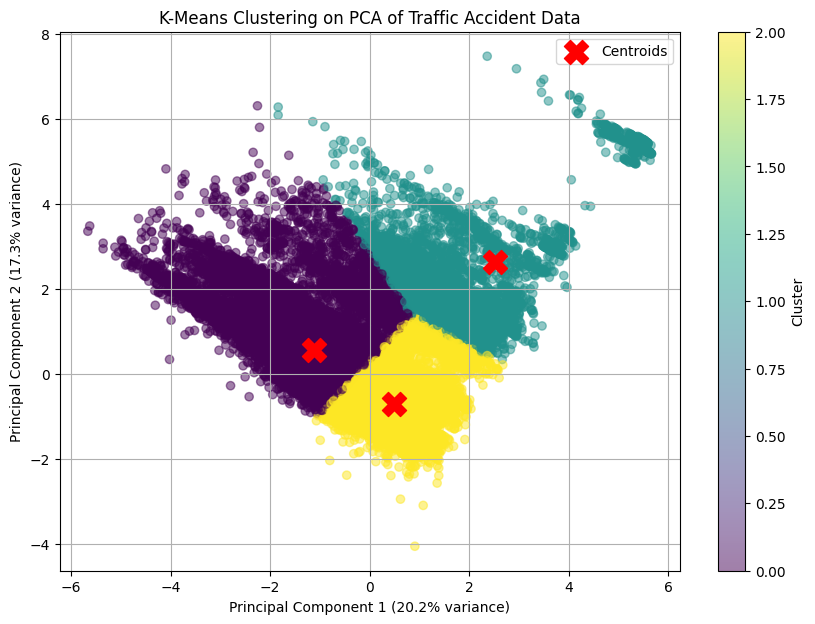

In [56]:
# Apply PCA (using the previous principal components we computed)
principal_components = pca.fit_transform(scaled_features)  # Make sure scaled_features is already standardized

# Apply K-Means clustering on the PCA components
kmeans = KMeans(n_clusters=3, random_state=42)
data['cluster'] = kmeans.fit_predict(principal_components)

# Plot clusters in the PCA space
plt.figure(figsize=(10, 7))
scatter = plt.scatter(principal_components[:, 0], principal_components[:, 1], c=data['cluster'], cmap='viridis', alpha=0.5)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=300, c='red', marker='X', label='Centroids')
plt.title('K-Means Clustering on PCA of Traffic Accident Data')
plt.xlabel(f'Principal Component 1 ({pca.explained_variance_ratio_[0]*100:.1f}% variance)')
plt.ylabel(f'Principal Component 2 ({pca.explained_variance_ratio_[1]*100:.1f}% variance)')
plt.legend()
plt.colorbar(scatter, label='Cluster')
plt.grid(True)
plt.show()


## 4. Discriminant Analysis

Classify accident severity based on other features, such as number of vehicles involved, latitude, and longitude.

Helps identify features that distinguish high-severity from low-severity accidents, assisting in preventive measures.

In [32]:
# Apply Discriminant Analysis
lda = LinearDiscriminantAnalysis()
X = data[['number_of_vehicles', 'latitude', 'longitude']]
y = data['accident_severity']
lda.fit(X, y)

# Print accuracy of classification (optional)
print(f"LDA classification accuracy: {lda.score(X, y)}")

LDA classification accuracy: 0.760691057690463


## 5. Hypothesis Testing: Weekday vs. Weekend Severity

### Hypotheses:

### Interpretation:

- **Null Hypothesis (H₀)**: There is no significant difference in accident severity between weekdays and weekends.
- **Alternative Hypothesis (H₁)**: Accident severity significantly differs between weekdays and weekends.

A low p-value (<0.05) would suggest rejecting the null hypothesis, indicating that weekday and weekend severities differ.

In [36]:
data['DayType'] = data['day_of_week'].apply(lambda x: 'Weekday' if x <= 5 else 'Weekend')
weekday_severity = data[data['DayType'] == 'Weekday']['accident_severity']
weekend_severity = data[data['DayType'] == 'Weekend']['accident_severity']

# Perform t-test
t_stat, p_val = ttest_ind(weekday_severity, weekend_severity)
print(f"T-test Statistic: {t_stat}, P-value: {p_val}")

# Interpret the result
if p_val < 0.05:
    print("Significant difference in accident severity between weekdays and weekends.")
else:
    print("No significant difference in accident severity between weekdays and weekends.")

T-test Statistic: 4.9129441965922025, P-value: 8.985448127397599e-07
Significant difference in accident severity between weekdays and weekends.


## 6. ANOVA: Comparing Accident Severity Across Days

### Hypotheses:

### Why Use ANOVA?

### Interpretation:

- **Null Hypothesis (H₀)**: There is no significant difference in accident severity across different days of the week.
- **Alternative Hypothesis (H₁)**: Accident severity significantly differs across days.

ANOVA helps test if multiple groups (days of the week) have different mean severity, useful for identifying high-risk days.

A low p-value (<0.05) would indicate rejecting the null hypothesis, suggesting that severity varies significantly across days.

In [57]:
# Display mean accident severity by day of the week
day_means = data.groupby('day_of_week')['accident_severity'].mean()
print("Mean Accident Severity by Day of the Week:")
print(day_means)

# Perform ANOVA
model = ols('accident_severity ~ C(day_of_week)', data=data).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print("\nANOVA Table:")
print(anova_table)

# Check if the ANOVA result is significant
if anova_table["PR(>F)"].iloc[0] < 0.05:

    print("\nThe ANOVA test is significant, indicating differences in accident severity across days.")
else:
    print("\nThe ANOVA test is not significant, indicating no significant differences in accident severity across days of the week.")


Mean Accident Severity by Day of the Week:
day_of_week
1    2.713480
2    2.753115
3    2.766948
4    2.755064
5    2.755701
6    2.746787
7    2.721086
Name: accident_severity, dtype: float64

ANOVA Table:
                      sum_sq        df         F        PR(>F)
C(day_of_week)     31.457982       6.0  24.00697  1.472576e-28
Residual        22765.252952  104239.0       NaN           NaN

The ANOVA test is significant, indicating differences in accident severity across days.


The ANOVA results show a significant effect of day of the week on accident severity (p < 0.05), meaning severity varies by day. The NaN values in the residual row are expected, as F-statistics and p-values are not applicable for residuals.

## 7. Variance Analysis by Day

Identify days with high variability in accident severity, which may suggest inconsistent factors affecting severity.

High variance on specific days might indicate outliers or unusual patterns in accident severity, possibly linked to special events, holidays, or environmental factors.

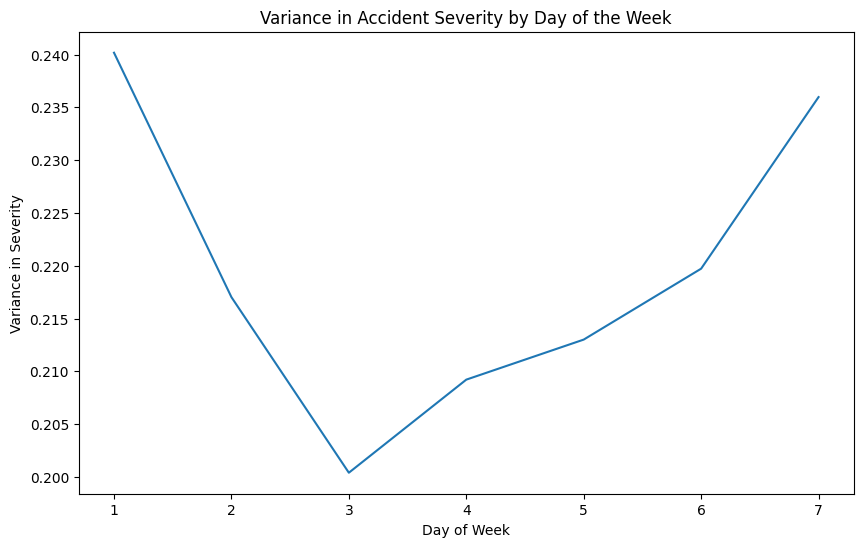

In [44]:
# Calculate and plot variance by day of the week
variance_by_day = data.groupby('day_of_week')['accident_severity'].var()

plt.figure(figsize=(10, 6))
variance_by_day.plot(kind='line')
plt.title('Variance in Accident Severity by Day of the Week')
plt.xlabel('Day of Week')
plt.ylabel('Variance in Severity')
plt.show()

## Summary and Reflections

### Practical Application:

This analysis covered advanced EDA techniques, including dimensionality reduction, cluster analysis, and hypothesis testing.

- How do each of these techniques aid in identifying patterns and insights in data?
- What workplace applications could benefit from each analysis technique covered?

The insights gained from PCA, clustering, discriminant analysis and hypothesis testing can help inform and support data driven decision making.